### Imports

In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from keras.models import load_model
from PIL import Image
import glob
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize


### Fetching the training history

In [2]:
with open('training_history.pickle', 'rb') as f:
    trainingHistory = pickle.load(f)


### Loading the model

In [3]:
model = load_model('BrainTumourClassificationModel.h5')

# ignore the warning below. it is a known issue. also, metrics can be built since training history was and fetched above. 

### Test set extraction

In [4]:

# directory containing the test data
testDirectory = 'TumourDataSet/Testing/'

#glob to find all files in the test directory, considering all subdirectories
all_files_pattern = os.path.join(testDirectory, '*/*')
all_file_paths = glob.glob(all_files_pattern)

# Filtering .DS_Store file
filtered_file_paths = [path for path in all_file_paths if not path.endswith('.DS_Store')]

# Extracting labels (subdirectory names) from the file paths
extracted_labels = [os.path.basename(os.path.dirname(path)) for path in filtered_file_paths]

# data frame created directly from the file paths and labels
testDataFrame = pd.DataFrame({
    'FilePaths': filtered_file_paths,
    'Labels': extracted_labels
})


### Preprocessing and creation of test set generator

In [5]:

# Constants for the image size and batch size
IMG_SIZE = (256, 256)
BATCH_SIZE = 16

# Function to read and preprocess the image
def preprocess_image(file_path, img_size=IMG_SIZE):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img / 255.0  # Normalize the images

# Function to create a dataset from a DataFrame
def create_dataset(df, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
    paths = df['FilePaths'].values
    labels = pd.get_dummies(df['Labels']).values  # One-hot encode labels
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: (preprocess_image(x, img_size), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# testGeneration dataset
testGeneration = create_dataset(testDataFrame)

### Plot for accuracy and loss

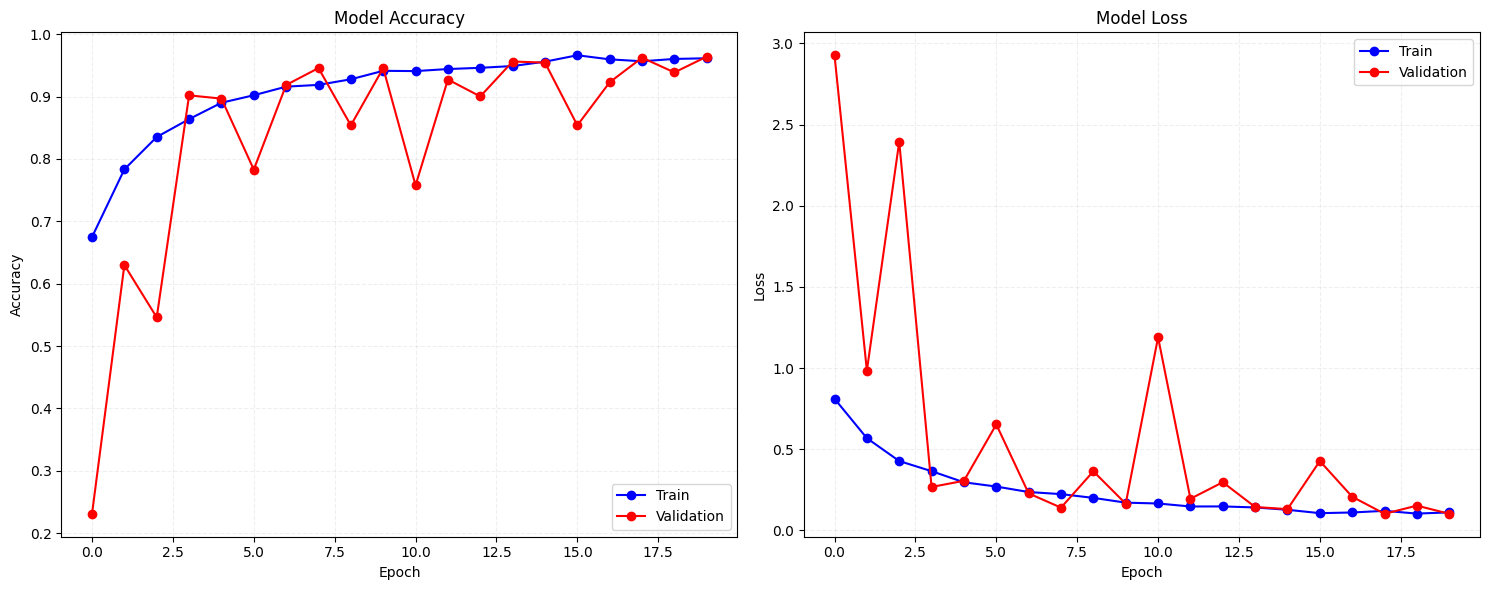

In [15]:
# figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for accuracy
accuracy_lines = ax1.plot(trainingHistory['accuracy'], 'o-b', trainingHistory['val_accuracy'], 'o-r')
ax1.set(title='Model Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax1.legend(accuracy_lines, ['Train', 'Validation'], loc='lower right')
ax1.grid(True, linestyle='--', alpha=0.2)

# Plotting for loss
loss_lines = ax2.plot(trainingHistory['loss'], 'o-b', trainingHistory['val_loss'], 'o-r')
ax2.set(title='Model Loss', xlabel='Epoch', ylabel='Loss')
ax2.legend(loss_lines, ['Train', 'Validation'], loc='upper right')
ax2.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()



### Sample predictions with test set on model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


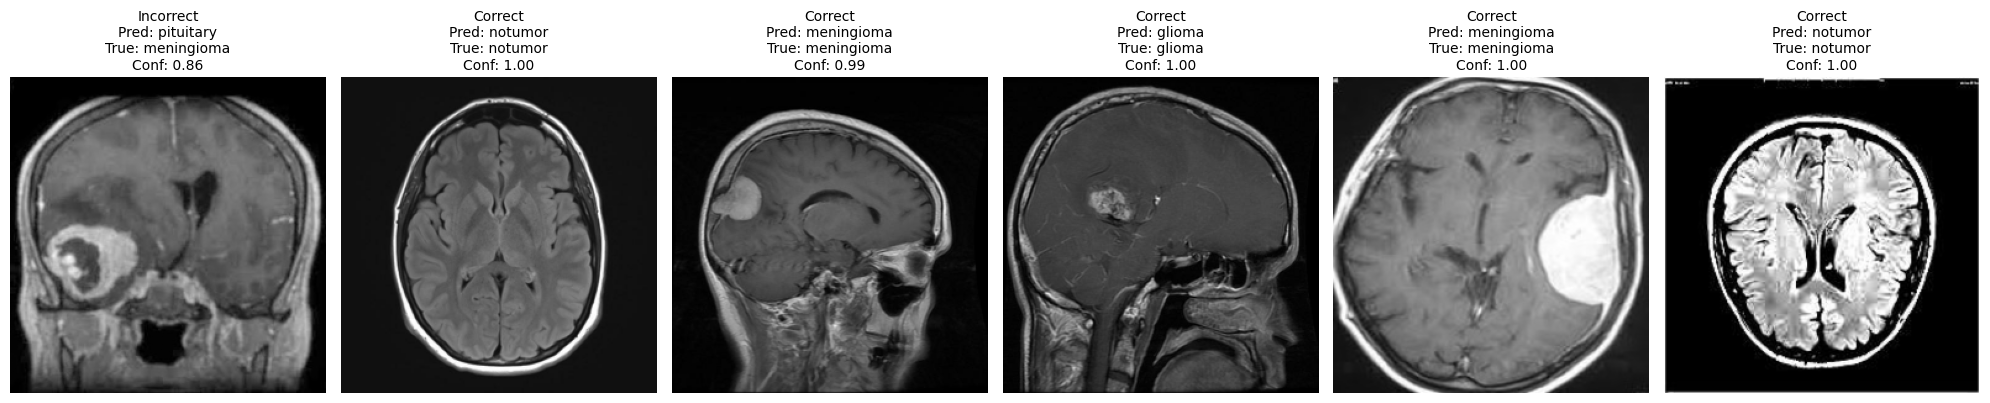

In [7]:
# number of images displayed
displayImageNumber = 6

# batch of test images and labels
test_images, test_labels = next(iter(testGeneration.unbatch().shuffle(buffer_size=1000).batch(displayImageNumber)))

# Make predictions
predictions = model.predict(test_images)

# predicted classes and their confidence
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels.numpy(), axis=1)
confidence_scores = np.max(predictions, axis=1)

# class labels mapping to get the actual class names
unique_labels = sorted(testDataFrame['Labels'].unique())
class_labels = {index: label for index, label in enumerate(unique_labels)}

# images with predictions, confidence, and correctness
fig, axes = plt.subplots(1, displayImageNumber, figsize=(20, 4))  # 1 row, displayImageNumber columns

# Display images with predictions
for i in range(displayImageNumber):
   
    axes[i].imshow(test_images[i].numpy(), cmap='gray')  
    
    predicted_label_name = class_labels[predicted_classes[i]]
    true_label_name = class_labels[true_classes[i]]
    correctness = "Correct" if predicted_classes[i] == true_classes[i] else "Incorrect"
    confidence = confidence_scores[i]
    
    title_text = f"{correctness}\nPred: {predicted_label_name}\nTrue: {true_label_name}\nConf: {confidence:.2f}"
    axes[i].set_title(title_text, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### ROC Curve

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 283ms/step


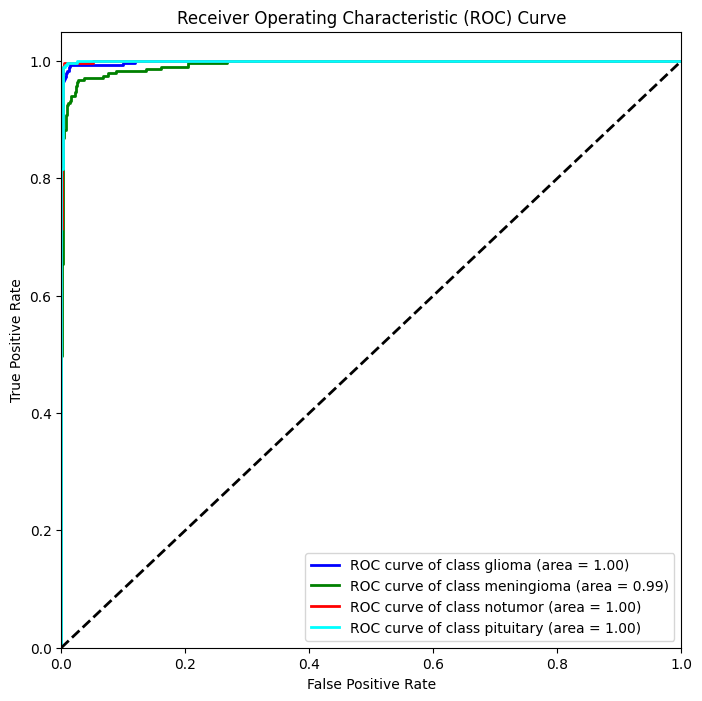

In [8]:

# Fetch all images and labels from the test dataset
test_images = []
test_labels = []
for images, labels in testGeneration.unbatch():  # Unbatching the dataset
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

# lists to numpy arrays for efficient computations
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# predictions on the entire test dataset
test_probs = model.predict(test_images)

# the number of classes based on the shape of the predictions
n_classes = test_probs.shape[1]

# Binarize the labels for ROC curve plotting
test_true_bin = label_binarize(test_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_true_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 8))  # Adjust the size of the figure as needed

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

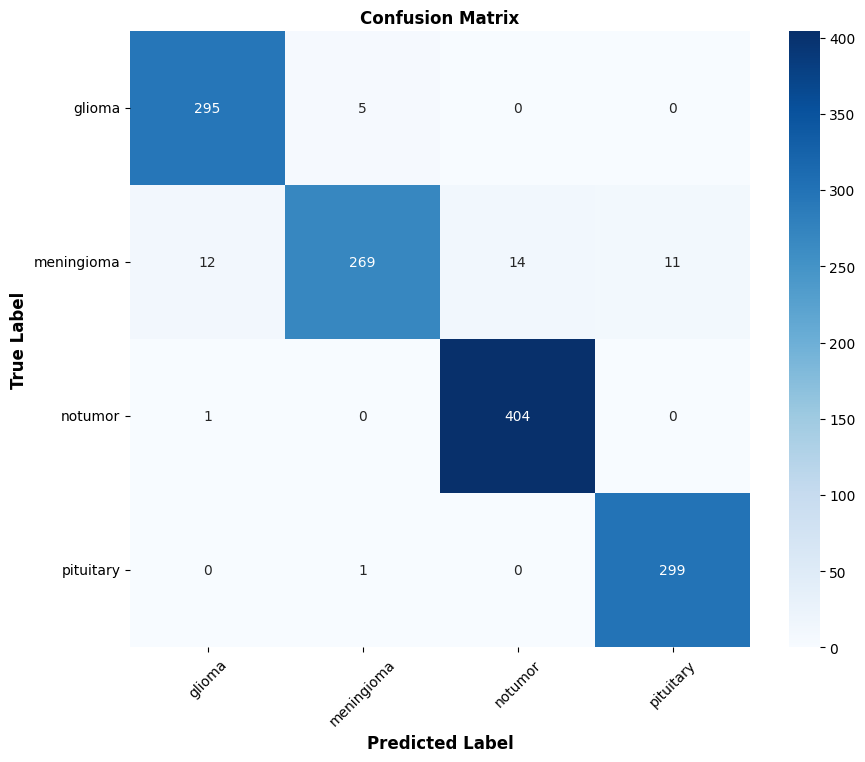

In [9]:

# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in testGeneration:
    true_labels = np.argmax(labels.numpy(), axis=1)
    y_true.extend(true_labels)
    
    #model predictions for each image in the batch
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_labels)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Confusion Matrix', weight = 'bold', fontsize = 12)
plt.ylabel('True Label', weight = 'bold', fontsize = 12)
plt.xlabel('Predicted Label', weight = 'bold', fontsize = 12)
plt.show()


### Precision, Recall, F1-Score and Classification Report

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

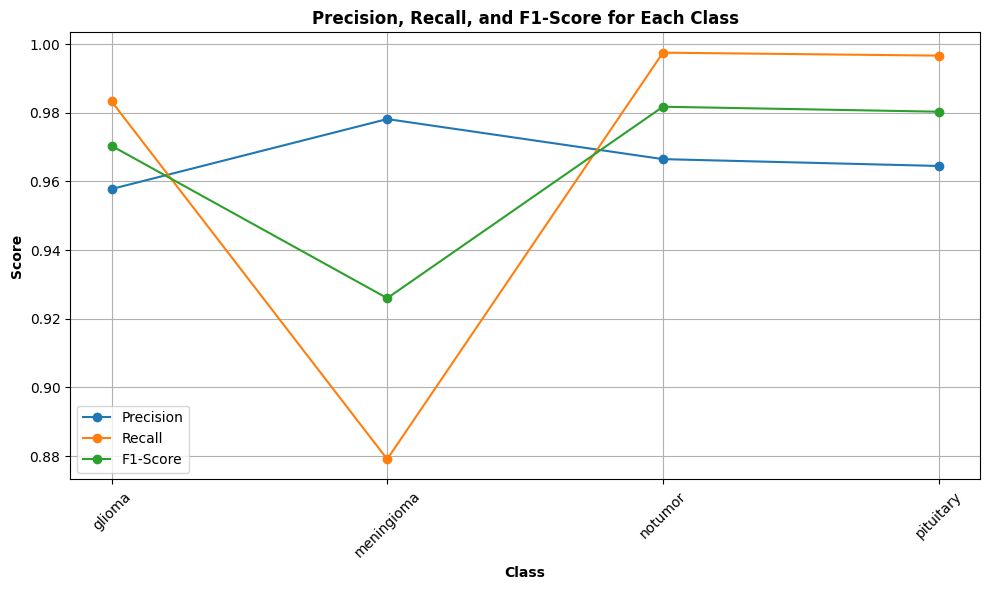

              precision    recall  f1-score   support

      glioma       0.96      0.98      0.97       300
  meningioma       0.98      0.88      0.93       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311



In [10]:

# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in testGeneration:
    true_labels = np.argmax(labels.numpy(), axis=1)
    y_true.extend(true_labels)
    
    #model predictions for each image in the batch
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_labels)

# classification report
class_labels = sorted(testDataFrame['Labels'].unique())  # Ensure consistent order
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Extract precision, recall, and f1-score
precision = [report[class_label]['precision'] for class_label in class_labels]
recall = [report[class_label]['recall'] for class_label in class_labels]
f1_score = [report[class_label]['f1-score'] for class_label in class_labels]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(class_labels, precision, marker='o', linestyle='-', label='Precision')
plt.plot(class_labels, recall, marker='o', linestyle='-', label='Recall')
plt.plot(class_labels, f1_score, marker='o', linestyle='-', label='F1-Score')
plt.title('Precision, Recall, and F1-Score for Each Class', weight = 'bold')
plt.xlabel('Class', weight = 'bold')
plt.ylabel('Score', weight = 'bold')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# print the classification report
print(classification_report(y_true, y_pred, target_names=class_labels))
